<h1> NBA Player Improvement Predictor </h1> 

This project intends to build a prediction model to predict the year to year improvement of players. It will use the change in Win Share statistic as the target to be predicted. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
Complete_df = pd.read_csv(r'C:\Users\ASUS\Desktop\Kaggle\Cleandf.csv')

In [3]:
features = Complete_df.columns.tolist()
features.remove('WS')
features.extend(['WS'])
Complete_df = Complete_df[features]
Complete_df.head(5)

,Player ID,Year,Player,Pos,Age,Tm,G,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS/48,OBPM,DBPM,BPM,VORP,WS
0,abdelal01,1991,Alaa Abdelnaby,PF,22,POR,43,0.0,290,55,...,14.0,22.1,0.0,0.5,0.079,-3.4,-1.2,-4.6,-0.2,0.5
1,abdelal01,1992,Alaa Abdelnaby,PF,23,POR,71,1.0,934,178,...,14.0,20.6,0.6,1.5,0.110,-2.3,-0.4,-2.6,-0.1,2.1
2,abdelal01,1993,Alaa Abdelnaby,PF,24,TOT,75,52.0,1311,245,...,15.6,20.5,0.7,1.3,0.074,-2.4,-1.5,-3.9,-0.6,2.0
3,abdelal01,1994,Alaa Abdelnaby,PF,25,BOS,13,0.0,159,24,...,20.5,22.6,-0.2,0.1,-0.032,-5.3,-2.2,-7.4,-0.2,-0.1
4,abdelal01,1995,Alaa Abdelnaby,PF,26,TOT,54,0.0,506,118,...,15.4,25.6,-0.4,0.7,0.027,-4.4,0.1,-4.3,-0.3,0.3


In [4]:
#finding the year to year change in WS
player_grouping = Complete_df.groupby(['Player ID'])

key_list_players = list()


for key,group in player_grouping:
    key_list_players.append(key)

i = 0
deltaWS_df = None
for key in key_list_players:
    temp = player_grouping.get_group(key)
    deltaWS = temp[["WS"]].diff()[1:]
    idx = temp.index.values.tolist()
    deltaWS.index = idx[:-1]
    temp = temp.iloc[:-1,:-1]
    temp["deltaWS"] = deltaWS
    if i == 0:
        deltaWS_df = temp
        i = 1
    else:
        deltaWS_df = pd.concat([deltaWS_df,temp], axis = 0)

In [5]:
deltaWS_df.head(10)

,Player ID,Year,Player,Pos,Age,Tm,G,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS/48,OBPM,DBPM,BPM,VORP,deltaWS
0,abdelal01,1991,Alaa Abdelnaby,PF,22,POR,43,0.000000,290,55,...,14.0,22.1,0.0,0.5,0.079,-3.4,-1.2,-4.6,-0.2,1.6
1,abdelal01,1992,Alaa Abdelnaby,PF,23,POR,71,1.000000,934,178,...,14.0,20.6,0.6,1.5,0.110,-2.3,-0.4,-2.6,-0.1,-0.1
2,abdelal01,1993,Alaa Abdelnaby,PF,24,TOT,75,52.000000,1311,245,...,15.6,20.5,0.7,1.3,0.074,-2.4,-1.5,-3.9,-0.6,-2.1
3,abdelal01,1994,Alaa Abdelnaby,PF,25,BOS,13,0.000000,159,24,...,20.5,22.6,-0.2,0.1,-0.032,-5.3,-2.2,-7.4,-0.2,0.4
5,abdulka01,1980,Kareem Abdul-Jabbar,C,32,LAL,82,79.666667,3143,835,...,15.7,24.1,9.5,5.3,0.227,4.8,2.4,7.2,7.3,-0.5
6,abdulka01,1981,Kareem Abdul-Jabbar,C,33,LAL,80,79.666667,2976,836,...,12.8,26.3,9.6,4.6,0.230,4.7,1.4,6.1,6.1,-3.6
7,abdulka01,1982,Kareem Abdul-Jabbar,C,34,LAL,76,76.000000,2677,753,...,13.3,25.6,6.9,3.9,0.192,3.8,1.2,5.0,4.7,0.2
8,abdulka01,1983,Kareem Abdul-Jabbar,C,35,LAL,79,79.000000,2554,722,...,12.6,24.6,8.0,2.9,0.205,4.0,0.5,4.5,4.2,-2.0
9,abdulka01,1984,Kareem Abdul-Jabbar,C,36,LAL,80,80.000000,2622,716,...,13.5,25.1,5.9,3.1,0.163,2.8,0.2,3.0,3.3,2.3
10,abdulka01,1985,Kareem Abdul-Jabbar,C,37,LAL,79,79.000000,2630,723,...,12.5,24.3,7.6,3.6,0.204,3.9,1.2,5.1,4.8,-0.4


In [6]:
deltaWS_df.reset_index(drop = True, inplace = True)
deltaWS_df.to_csv("DeltaWS.csv",index = False)

Now we have made the dataset to include the target variable for Predicting Player improvement. 

The year to year change in Win Shares(WS) of each player is selected as the target variable. The following analysis justifies why year to year change in WS is selected. 

The following analysis shows that the change in WS is often the highest in players who won the Most Improved Player award. 

In [7]:
import unidecode
deltaWS_df_mip = deltaWS_df.copy()
mip_data = pd.read_csv("MIP.csv")
mip_data["Won MIP"] = int(1)
mip_data.drop(['Lg'],axis = 1, inplace = True)
mip_data["Player"] = mip_data["Player"].apply(lambda x: unidecode.unidecode(x))
mip_data

,Season,Player,Won MIP
0,2018-19,Pascal Siakam,1
1,2017-18,Victor Oladipo,1
2,2016-17,Giannis Antetokounmpo,1
3,2015-16,CJ McCollum,1
4,2014-15,Jimmy Butler,1
5,2013-14,Goran Dragic,1
6,2012-13,Paul George,1
7,2011-12,Ryan Anderson,1
8,2010-11,Kevin Love,1
9,2009-10,Aaron Brooks,1


In [8]:
deltaWS_df_mip.shape

(13525, 52)

In [9]:
deltaWS_df_mip = pd.merge(deltaWS_df_mip,mip_data, how = 'left', on = ["Season", "Player"])
deltaWS_df_mip

,Player ID,Year,Player,Pos,Age,Tm,G,GS,MP,FG,...,USG%,OWS,DWS,WS/48,OBPM,DBPM,BPM,VORP,deltaWS,Won MIP
0,abdelal01,1991,Alaa Abdelnaby,PF,22,POR,43,0.000000,290,55,...,22.1,0.0,0.5,0.079,-3.4,-1.2,-4.6,-0.2,1.6,NaN
1,abdelal01,1992,Alaa Abdelnaby,PF,23,POR,71,1.000000,934,178,...,20.6,0.6,1.5,0.110,-2.3,-0.4,-2.6,-0.1,-0.1,NaN
2,abdelal01,1993,Alaa Abdelnaby,PF,24,TOT,75,52.000000,1311,245,...,20.5,0.7,1.3,0.074,-2.4,-1.5,-3.9,-0.6,-2.1,NaN
3,abdelal01,1994,Alaa Abdelnaby,PF,25,BOS,13,0.000000,159,24,...,22.6,-0.2,0.1,-0.032,-5.3,-2.2,-7.4,-0.2,0.4,NaN
4,abdulka01,1980,Kareem Abdul-Jabbar,C,32,LAL,82,79.666667,3143,835,...,24.1,9.5,5.3,0.227,4.8,2.4,7.2,7.3,-0.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13520,zidekge01,1997,George Zidek,C,23,TOT,52,2.000000,376,49,...,21.0,0.1,0.2,0.034,-4.4,-2.6,-6.9,-0.5,-0.3,NaN
13521,zipsepa01,2017,Paul Zipser,SF,22,CHI,44,18.000000,843,88,...,14.4,-0.3,0.8,0.030,-4.2,-0.2,-4.4,-0.5,-1.1,NaN
13522,zizican01,2018,Ante Zizic,C,21,CLE,32,2.000000,214,49,...,18.8,0.9,0.2,0.231,1.9,-0.9,1.0,0.2,1.0,NaN
13523,zubaciv01,2017,Ivica Zubac,C,19,LAL,38,11.000000,609,126,...,20.3,0.6,0.5,0.086,-1.2,-0.6,-1.7,0.0,-0.1,NaN


In [10]:
deltaWS_df_mip.loc[deltaWS_df_mip["Won MIP"].isna(),'Won MIP'] = int(0)
deltaWS_df_mip

,Player ID,Year,Player,Pos,Age,Tm,G,GS,MP,FG,...,USG%,OWS,DWS,WS/48,OBPM,DBPM,BPM,VORP,deltaWS,Won MIP
0,abdelal01,1991,Alaa Abdelnaby,PF,22,POR,43,0.000000,290,55,...,22.1,0.0,0.5,0.079,-3.4,-1.2,-4.6,-0.2,1.6,0.0
1,abdelal01,1992,Alaa Abdelnaby,PF,23,POR,71,1.000000,934,178,...,20.6,0.6,1.5,0.110,-2.3,-0.4,-2.6,-0.1,-0.1,0.0
2,abdelal01,1993,Alaa Abdelnaby,PF,24,TOT,75,52.000000,1311,245,...,20.5,0.7,1.3,0.074,-2.4,-1.5,-3.9,-0.6,-2.1,0.0
3,abdelal01,1994,Alaa Abdelnaby,PF,25,BOS,13,0.000000,159,24,...,22.6,-0.2,0.1,-0.032,-5.3,-2.2,-7.4,-0.2,0.4,0.0
4,abdulka01,1980,Kareem Abdul-Jabbar,C,32,LAL,82,79.666667,3143,835,...,24.1,9.5,5.3,0.227,4.8,2.4,7.2,7.3,-0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13520,zidekge01,1997,George Zidek,C,23,TOT,52,2.000000,376,49,...,21.0,0.1,0.2,0.034,-4.4,-2.6,-6.9,-0.5,-0.3,0.0
13521,zipsepa01,2017,Paul Zipser,SF,22,CHI,44,18.000000,843,88,...,14.4,-0.3,0.8,0.030,-4.2,-0.2,-4.4,-0.5,-1.1,0.0
13522,zizican01,2018,Ante Zizic,C,21,CLE,32,2.000000,214,49,...,18.8,0.9,0.2,0.231,1.9,-0.9,1.0,0.2,1.0,0.0
13523,zubaciv01,2017,Ivica Zubac,C,19,LAL,38,11.000000,609,126,...,20.3,0.6,0.5,0.086,-1.2,-0.6,-1.7,0.0,-0.1,0.0


In [11]:
rank_groups = deltaWS_df_mip.groupby('Season')
rank_groups_keys = list()

for key,group in rank_groups:
    rank_groups_keys.append(key)

i = 0
for key in rank_groups_keys:
    temp = rank_groups.get_group(key)
    temp["deltaWS_Rank"] = temp["deltaWS"].rank(ascending = True)
    temp.sort_values(by = "deltaWS_Rank",inplace = True, ascending = False)
    if i==0:
        df_WS_rank = temp
        i = 1
    else:
        df_WS_rank = df_WS_rank.append(temp,ignore_index=True)

<ipython-input-11-da8bc8414eac>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["deltaWS_Rank"] = temp["deltaWS"].rank(ascending = True)
<ipython-input-11-da8bc8414eac>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.sort_values(by = "deltaWS_Rank",inplace = True, ascending = False)


In [15]:
grouped_seasonal = df_WS_rank.groupby('Season')
key_list_seasonal = list()

for key,group in grouped_seasonal:
    key_list_seasonal.append(key)
ws_highest_rank = list()
season_list = list()
for key in key_list_seasonal:
    temp = grouped_seasonal.get_group(key)
    #getting the maximum change in WS for each year
    ws_highest_rank.append(temp["deltaWS_Rank"].max())
    season_list.append(key)
maximum_ws_seasonal = pd.DataFrame({"Season":season_list,"Highest WS Rank":ws_highest_rank})
maximum_ws_seasonal

,Season,Highest WS Rank
0,1980-81,225.0
1,1981-82,248.5
2,1982-83,257.0
3,1983-84,257.0
4,1984-85,261.0
5,1985-86,275.0
6,1986-87,266.0
7,1987-88,280.0
8,1988-89,276.0
9,1989-90,299.0


In [18]:
df_WS_rank = df_WS_rank.loc[df_WS_rank["Won MIP"] == 1]
df_WS_rank

,Player ID,Year,Player,Pos,Age,Tm,G,GS,MP,FG,...,OWS,DWS,WS/48,OBPM,DBPM,BPM,VORP,deltaWS,Won MIP,deltaWS_Rank
1249,roberal01,1985,Alvin Robertson,SG,22,SAS,79,9.0,1685,299,...,1.1,2.0,0.087,-0.2,1.1,0.9,1.2,5.5,1.0,275.0
1525,ellisda01,1986,Dale Ellis,SF,25,DAL,72,1.0,1086,193,...,1.2,0.4,0.071,1.1,-2.0,-0.9,0.3,7.7,1.0,265.0
1797,duckwke01,1987,Kevin Duckworth,C,22,TOT,65,1.0,875,130,...,-0.1,0.9,0.045,-5.1,-0.9,-6.0,-0.9,4.4,1.0,273.0
2070,johnske02,1988,Kevin Johnson,PG,21,TOT,80,28.0,1917,275,...,2.2,1.9,0.101,0.3,0.6,0.9,1.4,8.2,1.0,276.0
2356,seikaro01,1989,Rony Seikaly,C,23,MIA,78,62.0,1962,333,...,-2.7,2.2,-0.012,-4.4,-1.3,-5.8,-1.9,3.7,1.0,288.5
2650,skilesc01,1990,Scott Skiles,PG,25,ORL,70,32.0,1460,190,...,1.9,0.1,0.065,-0.2,-1.9,-2.0,0.0,5.0,1.0,315.5
2993,ellispe01,1991,Pervis Ellison,C,23,WSB,76,30.0,1942,326,...,1.1,2.9,0.100,-1.5,0.9,-0.6,0.7,2.9,1.0,306.5
3305,abdulma02,1992,Mahmoud Abdul-Rauf,PG,22,DEN,81,11.0,1538,356,...,-0.2,0.8,0.018,-1.2,-1.9,-3.1,-0.4,4.5,1.0,325.0
3636,macledo01,1993,Don MacLean,PF,23,WSB,62,4.0,674,157,...,0.1,0.3,0.030,-2.0,-2.7,-4.7,-0.5,5.2,1.0,323.5
3959,barroda01,1994,Dana Barros,PG,26,PHI,81,70.0,2519,412,...,3.9,0.8,0.089,1.7,-1.1,0.6,1.7,8.0,1.0,342.0


<ipython-input-19-4bd6d063cd35>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_mip.set_xticklabels(labels, rotation = 45)


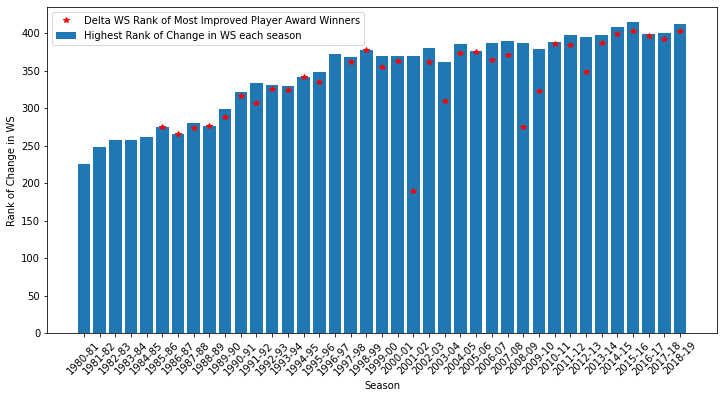

In [19]:
fig,ax_mip = plt.subplots(1,1,figsize = (12,6))
ax_mip.bar(maximum_ws_seasonal["Season"],maximum_ws_seasonal["Highest WS Rank"], label="Highest Rank of Change in WS each season")
ax_mip.plot(df_WS_rank["Season"],df_WS_rank["deltaWS_Rank"],'r*', label = 'Delta WS Rank of Most Improved Player Award Winners')
labels = maximum_ws_seasonal["Season"].unique().tolist()
ax_mip.set_xticklabels(labels, rotation = 45)
ax_mip.set_xlabel("Season")
ax_mip.set_ylabel("Rank of Change in WS")
ax_mip.legend()
plt.show()